In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing.image import image_dataset_from_directory
import os
from PIL import Image
from model_params import *
from dataTransformer import *
#tf.disable_v2_behavior()
import time


%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Loading data

In [3]:
DATA_ROOT = "asl_alphabet_train/"
batch_size = BATCH_SIZE
img_height,img_width,img_channels = IMG_DIM

seed = 12353
validation_split = 0.2
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
raw_train,val_ds,test_ds,class_names = load_dataset(DATA_ROOT,seed=seed)
num_classes = len(class_names)
train_ds = raw_train.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

Found 87000 files belonging to 29 classes.
Using 52200 files for training.
Found 87000 files belonging to 29 classes.
Using 34800 files for validation.


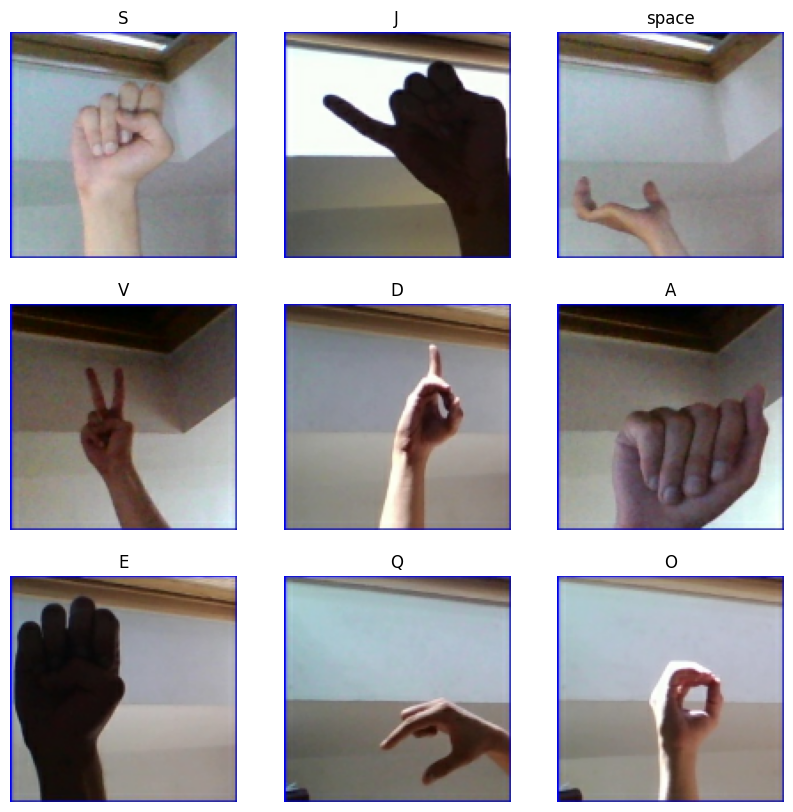

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

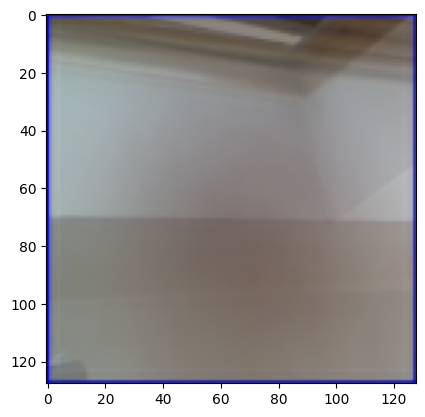

In [7]:
running_mean = tf.zeros(IMG_DIM)
img_num = 0
for imgs, lables in train_ds.take(100):
    
    running_mean = (img_num*running_mean+imgs.shape[0]*(tf.math.reduce_mean(imgs,0)/255))/(imgs.shape[0] + img_num)
    img_num+=imgs.shape[0]

plt.imshow(running_mean.numpy())

## Baseline model

Simple linear regression

In [8]:
lr_model = tf.keras.Sequential([
  tf.keras.layers.Resizing(INPUT_SHAPE[0],INPUT_SHAPE[1]),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes)
])

#using rms optimizer 
lr_model.compile(
  optimizer='rmsprop',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [9]:
history = lr_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100
)

Epoch 1/100
1632/1632 [==============================] - 11s 6ms/step - loss: 6.4381 - accuracy: 0.1169 - val_loss: 8.2855 - val_accuracy: 0.1190
Epoch 2/100
1632/1632 [==============================] - 6s 4ms/step - loss: 5.2467 - accuracy: 0.1882 - val_loss: 8.3983 - val_accuracy: 0.1575
Epoch 3/100
1632/1632 [==============================] - 6s 3ms/step - loss: 4.7517 - accuracy: 0.2274 - val_loss: 7.8938 - val_accuracy: 0.1553
Epoch 4/100
1632/1632 [==============================] - 6s 3ms/step - loss: 4.3936 - accuracy: 0.2561 - val_loss: 7.1740 - val_accuracy: 0.2194
Epoch 5/100
1632/1632 [==============================] - 6s 4ms/step - loss: 4.1175 - accuracy: 0.2859 - val_loss: 6.6308 - val_accuracy: 0.2129
Epoch 6/100
1632/1632 [==============================] - 6s 4ms/step - loss: 3.9008 - accuracy: 0.3100 - val_loss: 6.3389 - val_accuracy: 0.2115
Epoch 7/100
1632/1632 [==============================] - 6s 4ms/step - loss: 3.7444 - accuracy: 0.3265 - val_loss: 5.7128 - val_a

In [10]:
lr_res = evaluate_model(lr_model,test_ds,verbose=3,savePath="lr_model.keras")

544/544 [==============================] - 11s 17ms/step - loss: 2.4167 - accuracy: 0.5608
Test loss: 2.4167418479919434
Test accuracy: 0.5608325600624084
Model saved to lr_model.keras


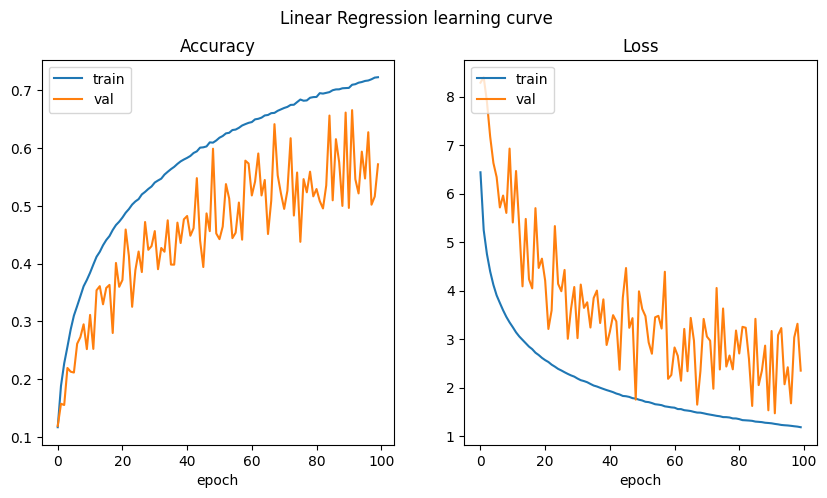

In [11]:
plot_curves(history, title="Linear Regression learning curve",save_fig=True)

## Neural Network

In [12]:
nn_model = tf.keras.Sequential([
  tf.keras.layers.Resizing(INPUT_SHAPE[0],INPUT_SHAPE[1]),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(num_classes)
])
nn_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [13]:
history = nn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=75
)

Epoch 1/75
1632/1632 [==============================] - 9s 5ms/step - loss: 2.5150 - accuracy: 0.2207 - val_loss: 1.8834 - val_accuracy: 0.3734
Epoch 2/75
1632/1632 [==============================] - 8s 5ms/step - loss: 1.6874 - accuracy: 0.4215 - val_loss: 1.5404 - val_accuracy: 0.4747
Epoch 3/75
1632/1632 [==============================] - 8s 5ms/step - loss: 1.3273 - accuracy: 0.5284 - val_loss: 1.1626 - val_accuracy: 0.5796
Epoch 4/75
1632/1632 [==============================] - 8s 5ms/step - loss: 1.1269 - accuracy: 0.5927 - val_loss: 1.0432 - val_accuracy: 0.6218
Epoch 5/75
1632/1632 [==============================] - 8s 5ms/step - loss: 1.0043 - accuracy: 0.6310 - val_loss: 0.8908 - val_accuracy: 0.6747
Epoch 6/75
1632/1632 [==============================] - 8s 5ms/step - loss: 0.9195 - accuracy: 0.6608 - val_loss: 0.8682 - val_accuracy: 0.6765
Epoch 7/75
1632/1632 [==============================] - 8s 5ms/step - loss: 0.8512 - accuracy: 0.6834 - val_loss: 1.0308 - val_accuracy:

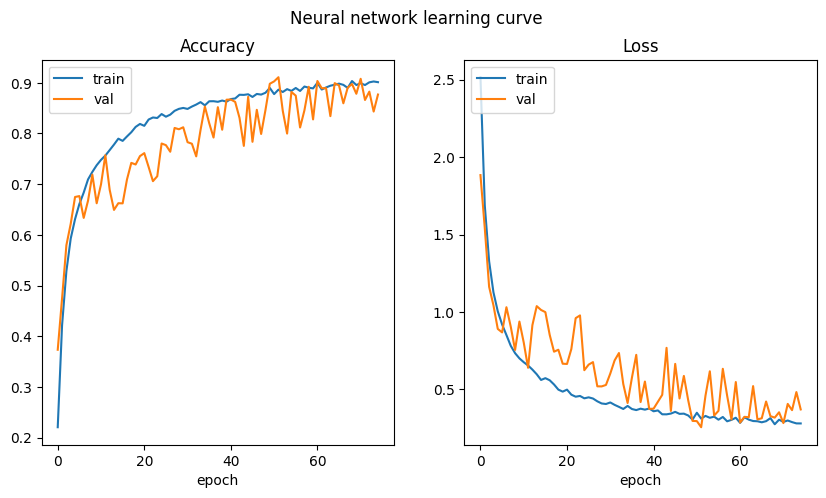

In [14]:
plot_curves(history, title="Neural network learning curve",save_fig=True)

In [15]:
nn_model_res = evaluate_model(nn_model,test_ds,verbose=3,savePath="neural_model.keras")

544/544 [==============================] - 2s 3ms/step - loss: 0.3678 - accuracy: 0.8782
Test loss: 0.367826372385025
Test accuracy: 0.8782198429107666
Model saved to neural_model.keras


## Preprocessing


In [16]:

from dataTransformer import *
train_ds_t = preprocess_ds(raw_train.cache(),preprocess,train=True).batch(batch_size,num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
val_ds_t = preprocess_ds(val_ds,preprocess).prefetch(buffer_size=AUTOTUNE)
test_ds_t = preprocess_ds(test_ds,preprocess).prefetch(buffer_size=AUTOTUNE)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.3922217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


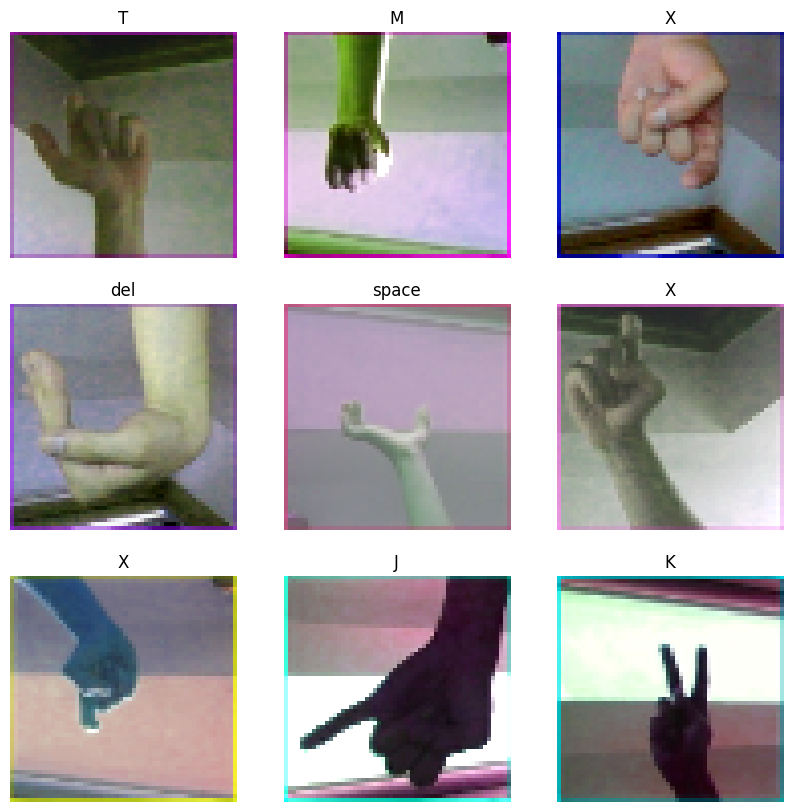

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_t.take(1):
  print(np.amax(images.numpy()))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

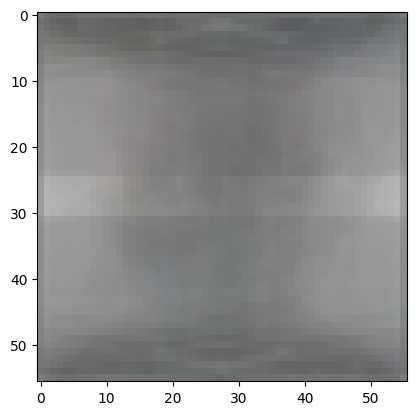

In [18]:
running_mean = tf.zeros(INPUT_SHAPE)
img_num = 0
for imgs, lables in train_ds_t.take(5):
    
    running_mean = (img_num*running_mean+imgs.shape[0]*(tf.math.reduce_mean(imgs,0)))/(imgs.shape[0] + img_num)
    img_num+=imgs.shape[0]

plt.imshow(running_mean.numpy())

## Neural network - Again

same model, 2.5m parameters

In [19]:
nn_model_t = tf.keras.Sequential([
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(num_classes)
])
nn_model_t.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [20]:
history = nn_model_t.fit(
  train_ds_t,
  validation_data=val_ds_t,
  epochs=75
)

Epoch 1/75
1632/1632 [==============================] - 91s 53ms/step - loss: 3.2515 - accuracy: 0.0668 - val_loss: 2.9893 - val_accuracy: 0.1130
Epoch 2/75
1632/1632 [==============================] - 7s 5ms/step - loss: 2.8485 - accuracy: 0.1371 - val_loss: 2.6455 - val_accuracy: 0.1857
Epoch 3/75
1632/1632 [==============================] - 7s 4ms/step - loss: 2.5411 - accuracy: 0.2060 - val_loss: 2.2577 - val_accuracy: 0.2916
Epoch 4/75
1632/1632 [==============================] - 7s 4ms/step - loss: 2.2548 - accuracy: 0.2861 - val_loss: 1.9895 - val_accuracy: 0.3523
Epoch 5/75
1632/1632 [==============================] - 7s 4ms/step - loss: 2.0456 - accuracy: 0.3419 - val_loss: 1.7764 - val_accuracy: 0.4044
Epoch 6/75
1632/1632 [==============================] - 7s 4ms/step - loss: 1.8961 - accuracy: 0.3840 - val_loss: 1.6287 - val_accuracy: 0.4588
Epoch 7/75
1632/1632 [==============================] - 7s 4ms/step - loss: 1.7774 - accuracy: 0.4181 - val_loss: 1.5459 - val_accurac

In [21]:
nn_model_t_res = evaluate_model(nn_model_t,test_ds_t,verbose=3,savePath="neural_model_transformations.keras")

544/544 [==============================] - 2s 3ms/step - loss: 0.6938 - accuracy: 0.7666
Test loss: 0.6937650442123413
Test accuracy: 0.7666168212890625
Model saved to neural_model_transformations.keras


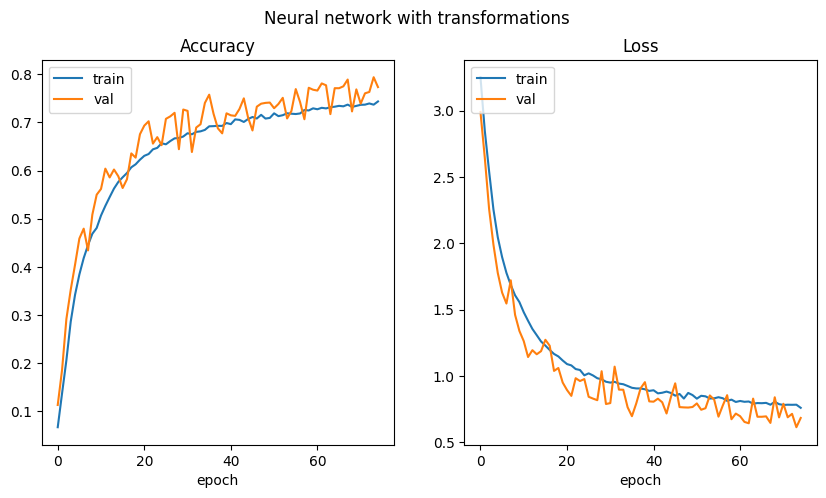

In [22]:

plot_curves(history, title="Neural network with transformations",save_fig=True)

## CNN - 12-layer Resnet

In [23]:
from dataTransformer import *

cnn_model = tf.keras.Sequential([
  
  tf.keras.layers.Conv2D(32, 7,padding='same',strides=1),#56x56
  ResnetBlock(5,filt=64,filt_in=32,num=2,stride=2),#28x28
  ResnetBlock(5,filt=64,num=2),

  ResnetBlock(3,filt=128,filt_in=64,num=2,stride=2),#14x14
  ResnetBlock(3,filt=128,filt_in=128,num=2),

  ResnetBlock(3,filt=256,filt_in=128,num=2,stride=2),#7x7
  ResnetBlock(3,filt=256,filt_in=256,num=2),

  tf.keras.layers.AveragePooling2D(7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes)
])
cnn_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
cnn_model.build([None,*INPUT_SHAPE])
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 32)        4736      
                                                                 
 resnet_block (ResnetBlock)  (None, 28, 28, 64)        205760    
                                                                 
 resnet_block_1 (ResnetBlock  (None, 28, 28, 64)       308160    
 )                                                               
                                                                 
 resnet_block_2 (ResnetBlock  (None, 14, 14, 128)      296832    
 )                                                               
                                                                 
 resnet_block_3 (ResnetBlock  (None, 14, 14, 128)      296192    
 )                                                               
                                                      

this model has only 3.4M params but preforms much better

In [24]:
history = cnn_model.fit(
  train_ds_t,
  callbacks=[],
  validation_data=val_ds_t,
  epochs=25)


Epoch 1/25
1632/1632 [==============================] - 31s 16ms/step - loss: 1.6433 - accuracy: 0.5018 - val_loss: 1.3861 - val_accuracy: 0.5955
Epoch 2/25
1632/1632 [==============================] - 25s 15ms/step - loss: 0.3015 - accuracy: 0.9024 - val_loss: 0.2474 - val_accuracy: 0.9180
Epoch 3/25
1632/1632 [==============================] - 25s 15ms/step - loss: 0.1422 - accuracy: 0.9539 - val_loss: 0.2704 - val_accuracy: 0.9104
Epoch 4/25
1632/1632 [==============================] - 25s 15ms/step - loss: 0.0995 - accuracy: 0.9678 - val_loss: 0.1399 - val_accuracy: 0.9536
Epoch 5/25
1632/1632 [==============================] - 25s 15ms/step - loss: 0.0707 - accuracy: 0.9774 - val_loss: 0.1590 - val_accuracy: 0.9500
Epoch 6/25
1632/1632 [==============================] - 24s 15ms/step - loss: 0.0554 - accuracy: 0.9821 - val_loss: 0.2311 - val_accuracy: 0.9280
Epoch 7/25
1632/1632 [==============================] - 25s 15ms/step - loss: 0.0441 - accuracy: 0.9855 - val_loss: 0.1472 -

In [25]:
cnn_model_res = evaluate_model(cnn_model,test_ds_t,verbose=3,savePath="resnet_model.keras")

544/544 [==============================] - 11s 19ms/step - loss: 0.0089 - accuracy: 0.9973
Test loss: 0.008949186652898788
Test accuracy: 0.9972975850105286
Model saved to resnet_model.keras


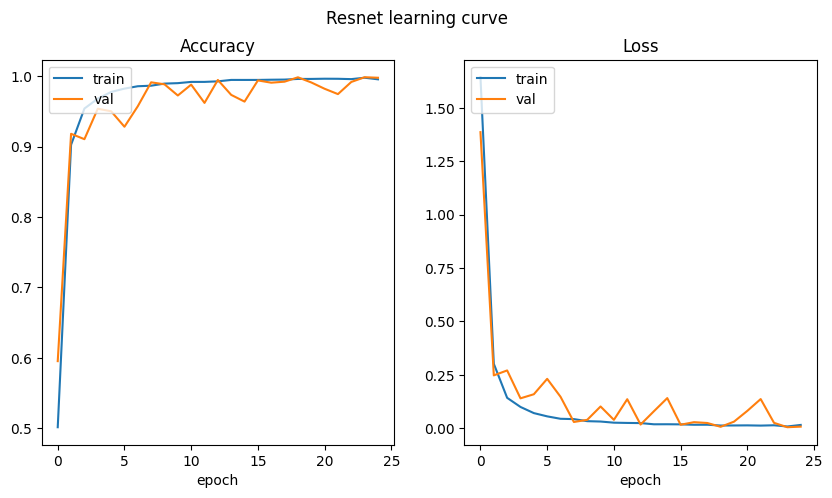

In [26]:
plot_curves(history,title="Resnet learning curve",save_fig=True)

## Comparison

tf.Tensor([10 15  9 ... 26 16 11], shape=(17392,), dtype=int32)


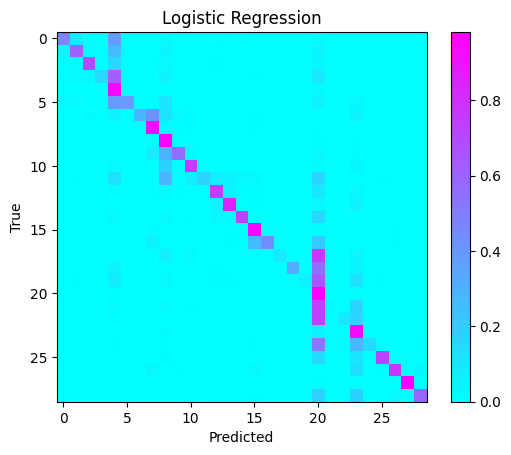

In [37]:
from dataTransformer import *
confusion_matrix(lr_model,test_ds,class_names,title="Logistic Regression",save_fig=True)

tf.Tensor([10 15  9 ... 26 16 11], shape=(17392,), dtype=int32)


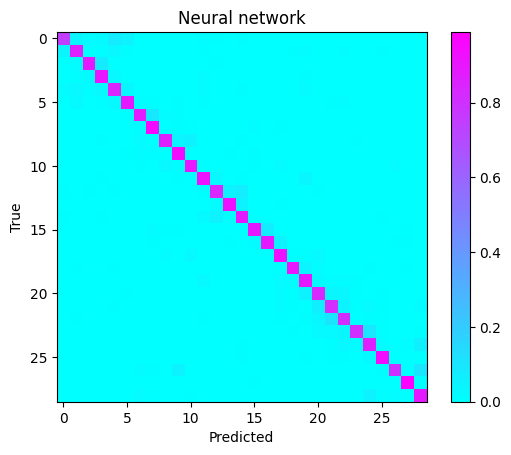

In [33]:
confusion_matrix(nn_model,test_ds,class_names,title="Neural network",save_fig=True)

tf.Tensor([10 15  9 ... 26 16 11], shape=(17392,), dtype=int32)


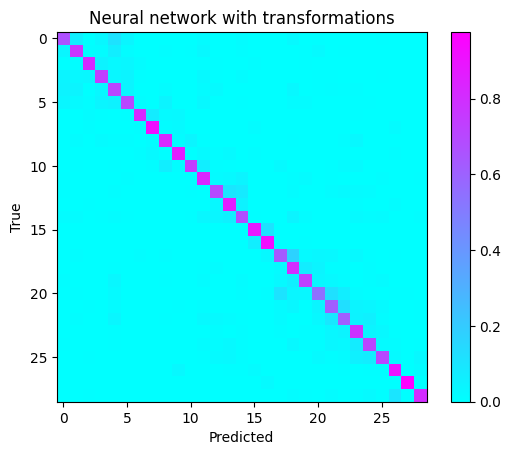

In [34]:
confusion_matrix(nn_model_t,test_ds_t,class_names,title="Neural network with transformations",save_fig=True)

tf.Tensor([10 15  9 ... 26 16 11], shape=(17392,), dtype=int32)


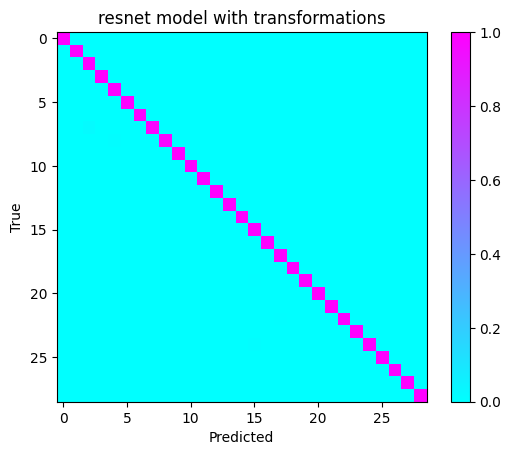

In [35]:
confusion_matrix(cnn_model,test_ds_t,class_names,title="resnet model with transformations",save_fig=True)